<img src='https://pennstatelaw.psu.edu/sites/default/files/styles/content_header_image/public/M%20and%20A%20center%201.jpg?itok=nxlHzngRhttps://pennstatelaw.psu.edu/sites/default/files/styles/content_header_image/public/M%20and%20A%20center%201.jpg?itok=nxlHzngR' height="100%" width="3500">

# Projeto Quant.dev

Olá! Seja bem vindo ao projeto de Quant do FEA.dev!

O que você irá fazer:

  "*Você é um sócio e analista quantitativo do nosso Fundo. Seu objetivo é apresentar sua estratégia de investimento e convencer os outros sócios a colocá-la no portfólio. Você tem boa parte do seu patrimônio pessoal investido nesse Fundo.*"

### Você decidiu implementar a seguinte estratégia:

A sua hipótese é que as ações mais negociadas no mês, ou seja, de maior volume, irão bem no mês seguinte. A sua regra de investimento será comprar, todo final de mês, as 10 ações com o maior volume do indice IBX. Você tem um montante inicial de R$100.000 para investir.

Comece extraindo os dados de preços e volume, tome cuidado que nem todas as fontes te dão essas informações. 

A composição do IBX a cada ano lhe foi dada no arquivo excel. O período de sua estratégia deve contemplar todo o período do mesmo arquivo.

Depois que sua estratégia estiver rodando sem erros, faça uma **análise minuciosa** da estratégia (a maior parte da sua avaliação de desempenho se dará nessa parte). Para isso, use métricas diversas (retorno, volatilidade, drawdown, etc.) plotando e comparando-as. Também faça variações dessa estratégia (comprar as 5 maiores, 10 maiores, 15 maiores, etc) e veja qual é a melhor.

Por fim, deixe mais do que claro se:

1. Está confiante para indicar essa ideia para o portfólio. ou  
2. Não chegou a um resultado satisfatório. ou  
3. Acha que precisa de mais estudos para se sentir confiante.

Obs: Não há problema se algumas ações derem erro na hora da extração, siga em frente. Mas se muitas estiverem dando erro, melhor revisar seu código...

### Materiais de apoio:
1. [Coursera: Introduction to Portfolio Construction and Analysis with Python (link)](https://www.coursera.org/programs/universidade-de-sao-paulo-br-on-coursera-mvxtw?currentTab=MY_COURSES&productId=qeyXSV_uEeiNIQqyU-T6bA&productType=course&showMiniModal=true) 

    - Semanas 1, 2 e 3

2. [Livro: Quantitative Trading - Ernest Chan (link)](https://drive.google.com/drive/folders/1pHySMzZjpHyvVOWn6Ect7CsZXmThzyAO)

    - Cap 1: Inteiro
    - Cap 2: 17-31
    - Cap 3: 36-69

3. [Playlist de Finanças Quantitativas do FEA.dev (link)](https://www.youtube.com/playlist?list=PLiJqHBsOKi2cabSus1hgdSNAHeU0md6_D)

In [1]:
# Imports
import pandas as pd
import numpy as np
from pandas_datareader import data as web
from datetime import datetime
from dateutil.relativedelta import relativedelta
from time import sleep
import fun_cas_qnt as fcq

In [2]:
# Para atualizar os imports
%load_ext autoreload
%autoreload 2

In [3]:
# Importando o csv das Ações mais volumosas segundo o índice IBX (comp_ibx)
comp_ibx = pd.read_csv("composicao_ibx_mensal.csv")
comp_ibx.set_index("Unnamed: 0", inplace=True) # Colocando a primeira coluna (datas) como index
comp_ibx.index = fcq.converte_index(datetime(2010, 12, 31), comp_ibx.shape[0]) # Padronizando o index

In [4]:
# Visualizando comp_ibx
comp_ibx

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
2010-12,ABEV3,AEDU3,ALLL3,AMIL3,B3SA3,BBAS3,BBDC3,BBDC4,BBRK3,BISA3,...,TRPL4,UGPA4,USIM3,USIM5,VALE3,VALE5,VIVO4,VIVR3,VIVT4,WEGE3
2011-01,ABEV3,AEDU3,ALLL3,AMIL3,B3SA3,BBAS3,BBDC3,BBDC4,BBRK3,BISA3,...,TRPL4,UGPA4,USIM3,USIM5,VALE3,VALE5,VIVO4,VIVR3,VIVT4,WEGE3
2011-02,ABEV3,AEDU3,ALLL3,AMIL3,B3SA3,BBAS3,BBDC3,BBDC4,BBRK3,BISA3,...,TRPL4,UGPA4,USIM3,USIM5,VALE3,VALE5,VIVO4,VIVR3,VIVT4,WEGE3
2011-03,ABEV3,AEDU3,ALLL3,AMIL3,B3SA3,BBAS3,BBDC3,BBDC4,BBRK3,BISA3,...,TRPL4,UGPA4,USIM3,USIM5,VALE3,VALE5,VIVO4,VIVR3,VIVT4,WEGE3
2011-04,ABEV3,AEDU3,ALLL3,AMIL3,B3SA3,BBAS3,BBDC3,BBDC4,BBRK3,BISA3,...,TOTS3,TRPL4,UGPA4,USIM3,USIM5,VALE3,VALE5,VIVO4,VIVT4,WEGE3


In [5]:
# Criando uma lista com todas ações que aparecem no IBX
lst_acoes = fcq.elementos_df(comp_ibx)

# Criando DataFrames para informações de adjusted close e volume
prices = pd.DataFrame(index=comp_ibx.index, columns=lst_acoes)
volume = pd.DataFrame(index=comp_ibx.index, columns=lst_acoes)

In [6]:
# Usando o Alpha Vantage para buscar preços e volumes das ações

for ticker in lst_acoes:
    try:
        info_acoes = web.DataReader(f"{ticker}.SAO", "av-monthly-adjusted",
                                   start=datetime(2010, 12, 31), end=datetime(2019, 12, 31),
                                   api_key=('ONPJ12F0EN771AWV')) # Pegando DF de ações no Alpha Vantage
        info_acoes.index = fcq.converte_index(datetime.strptime(info_acoes.index[0], '%Y-%m-%d').date(), 
                                              info_acoes.shape[0]) #Padronizando index 
        sleep(10) #Colocando um timer, devido a quantidade autorizada de extrações por minuto do AlphaVantage
        for linha in range(info_acoes.shape[0]):
            for linha2 in range(prices.shape[0]):
                if info_acoes.index[linha] == prices.index[linha2]:
                    prices.iloc[linha2][ticker] = float(info_acoes['adjusted close'][linha]) # Colocando valores em prices
                    volume.iloc[linha2][ticker] = float(info_acoes['volume'][linha]) # Colocando valores em volume
    except:
        None


In [26]:
# Visualizando a DF de preços (A de volumes é parecida)
prices

,NaN,AMBV3,LCAM3,LOGG3,ABEV3,IGTA3,COGN3,CCRO3,VALE3,FIBR3,...,TOTS3,AZUL4,MOVI3,OIBR4,TIMP3,EQTL3,MILS3,CVCB3,CTIP3,LEVE3
2010-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.869,22.3076,...,5.6102,NaN,NaN,14.7691,NaN,0.6066,20.0018,NaN,22.052,8.211
2011-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.3651,20.8076,...,5.4354,NaN,NaN,14.313,NaN,0.6179,18.0294,NaN,24.419,7.1752
2011-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.4596,22.8451,...,6.5573,NaN,NaN,16.6049,NaN,0.6657,17.1869,NaN,26.9658,7.3845
2011-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.854,21.9066,...,6.2748,NaN,NaN,16.9179,NaN,0.7019,20.6084,NaN,26.0669,7.4568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,NaN,NaN,17.7908,24.2768,18.2409,NaN,NaN,NaN,42.6123,NaN,...,17.7481,47.1,15.2033,1.64,NaN,18.6604,7.43,52.5611,NaN,22.4942
2019-09,NaN,NaN,16.4684,24.0291,18.7574,NaN,NaN,NaN,44.6509,NaN,...,19.0197,49.71,15.2008,1.43,NaN,19.5411,6.85,55.3145,NaN,22.5417
2019-10,NaN,NaN,16.8193,25.0695,16.9352,NaN,NaN,NaN,44.1366,NaN,...,20.5151,52.52,14.9496,1.31,NaN,19.8508,7.28,50.7388,NaN,23.3207
2019-11,NaN,NaN,16.9264,27.8836,17.5881,NaN,NaN,NaN,46.7361,NaN,...,21.3124,53.1,16.3899,1.25,NaN,20.1081,7.01,39.7551,NaN,24.0772


In [10]:
# Pegando N primeiras ações com maior volume segundo o indice IBX
n = 10
comp_ibx = comp_ibx[[str(w) for w in range(n)]] # Pegando as N primeiras ações
volume.fillna(0, inplace=True)
for linha in range(volume.shape[0]):
    v_volume = volume.iloc[linha].sort_values(ascending=False)
    for coluna in range(comp_ibx.shape[1]):
            comp_ibx.iloc[linha][coluna] = v_volume.index[coluna] 

In [11]:
# Visualidando nossa composição do IBX com maiores volumes
comp_ibx

,0,1,2,3,4,5,6,7,8,9
2010-12,VALE5,AEDU3,SUZB5,HGTX3,TRPL4,FLRY3,PDGR3,SUZB3,ENBR3,CSAN3
2011-01,PETR4,TESA3,B3SA3,VALE5,PDGR3,ITSA4,USIM5,ITUB4,RPMG3,GGBR4
2011-02,PETR4,TESA3,B3SA3,PDGR3,VALE5,ITSA4,ITUB4,BBAS3,USIM5,PETR3
2011-03,PETR4,TESA3,VALE5,B3SA3,PDGR3,CYRE3,GGBR4,USIM5,ITUB4,ITSA4
2011-04,PETR4,TESA3,VALE5,B3SA3,GGBR4,PDGR3,ITUB4,USIM5,MMXM3,BBAS3
...,...,...,...,...,...,...,...,...,...,...
2019-08,PETR4,ITSA4,VVAR3,VALE3,ABEV3,ITUB4,BBDC4,CIEL3,GGBR4,USIM5
2019-09,PETR4,VVAR3,ITSA4,ITUB4,ABEV3,VALE3,CIEL3,BBDC4,GGBR4,JBSS3
2019-10,PETR4,VVAR3,ABEV3,BBDC4,ITUB4,ITSA4,VALE3,CIEL3,BBAS3,USIM5
2019-11,PETR4,VVAR3,ITUB4,VALE3,BBDC4,ITSA4,GGBR4,JBSS3,MGLU3,USIM5


## Parte II - Definindo a Estratégia

### Faremos 2 estratégias para definir nosso tipo de portifólio:

Como nosso montante inicial é de R$ 100.000,00 utilizaremos de tais maneiras:

- 1º: Carteira Fixa, pegamos o montante e dividiremos em (100/N)% para cada ação, ou seja se compramos 10 ações (que tiveram o maior volume de vendas no mês anterior) por mês cada ação ira receber 10% do nosso montante.
- 2º: Carteira Variável pelo volume: o volume de cada mês definirá a porcentagem do nosso montante que sera investido em cada ação no mês seguinte. Ou seja, se uma ação teve um maior volume ela receberá um maior investimento.


###### Obs.: Ambas as carteiras sofrem mudanças conforme o mês, o que as difere é a porcentagem do montante que será investido em cada ação

## Carteira Fixa

In [27]:
# Calculando os Retornos de cada ação
retorno = prices.pct_change()
retorno.fillna(0, inplace=True) # Substituido valores NaN por 0

In [30]:
# Aplicando o Montante em cada mês utilizando a estratégia da carteira fixa
m_zero = 100000
montantes_f = comp_ibx.copy()
for linha in range(montantes_f.shape[0]):
    for coluna in range(montantes_f.shape[1]):
        montantes_f.iloc[linha][coluna] = (m_zero/n) * (retorno.iloc[linha][montantes_f.iloc[linha][coluna]] + 1)
    m_zero = montantes_f.iloc[linha].sum()

# Criando e isolando uma coluna com a soma do retorno para cada ação
montantes_f["Fixa"] = round(montantes_f.apply(lambda x: sum(x), axis=1), 2)
montantes_f = montantes_f[["Fixa"]]


In [31]:
fcq.riscos_retorno(montantes_f)

Volatilidade: 9.91%
Semivolatilidade: 4.57%
Risco Anual: 34.5%
Value at Risk (5%): 0.1028
Montante Final: R$243550.89
Retorno Final: 243.55%


## Carteira Variável pelo Volume

In [32]:
# Criando um DF de porcentagem de volume - weights vetors
pct_vol = comp_ibx.copy()
for linha in range(pct_vol.shape[0]):
    for coluna in range(pct_vol.shape[1]):
        pct_vol.iloc[linha][coluna] = volume.iloc[linha][pct_vol.iloc[linha][coluna]]
pct_vol.fillna(0, inplace=True)
pct_vol = pct_vol.apply(lambda x: x/pct_vol.sum(axis=1))

In [33]:
# Calculando os Retornos de cada asset
retorno = prices.pct_change()
retorno.fillna(0, inplace=True) # Substituindo NaN por 0
retorno += 1 # Calcular em cima do Montante

In [35]:
# Aplicando o Montante em cada mês utilizando a estratégia da carteira fixa
m_zero = 100000
montantes_v = comp_ibx.copy()
for linha in range(montantes_v.shape[0]):
    for coluna in range(montantes_v.shape[1]):
        montantes_v.iloc[linha][coluna] = m_zero * pct_vol.iloc[linha][coluna] * retorno.iloc[linha][montantes_v.iloc[linha][coluna]]
    m_zero = montantes_v.sum(axis=1)[linha]

# Criando e isolando uma coluna com a soma do retorno para cada ação
montantes_v["Variavel"] = round(montantes_v.apply(lambda x: sum(x), axis=1), 2)
montantes_v = montantes_v[["Variavel"]]

In [36]:
fcq.riscos_retorno(montantes_v)

Volatilidade: 10.74%
Semivolatilidade: 5.02%
Risco Anual: 37.38%
Value at Risk (5%): 0.118
Montante Final: R$204289.65
Retorno Final: 204.29%


In [19]:
# Criando um DataFrame para comparar ambas estratégias
montantes_f["Variavel"] = montantes_v["Variavel"]

<AxesSubplot:title={'center':'Curva de Crescimento do Montante'}>

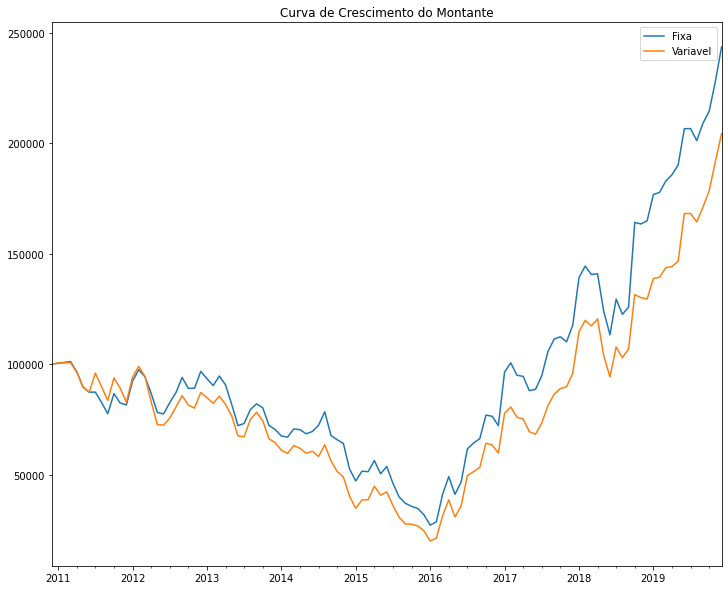

In [20]:
montantes_f.plot(title='Curva de Crescimento do Montante', figsize=(12, 10))

<AxesSubplot:title={'center':'Retornos Mensais'}>

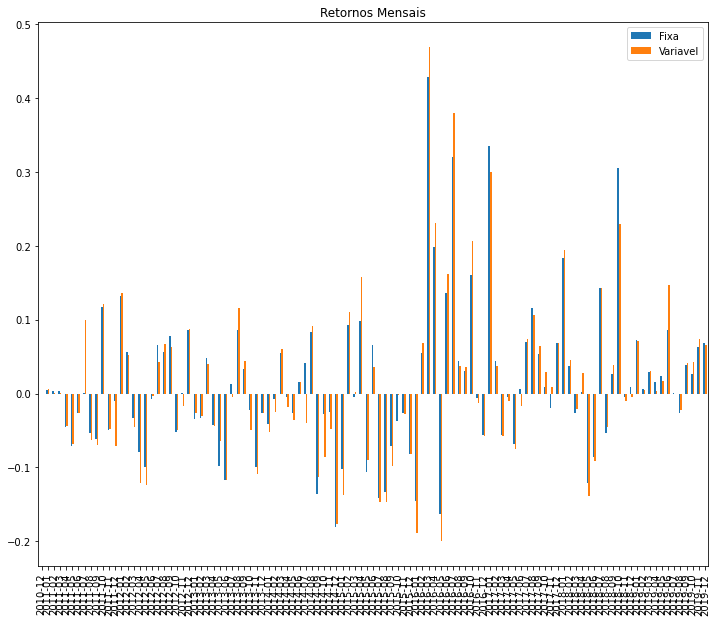

In [21]:
montantes_f.pct_change().plot.bar(title='Retornos Mensais', figsize=(12, 10))

## Parte III - Análise
Adotamos a estratégia 1, da Carteira Fixa, já que apresenta um menor risco e um maior retorno que a outra.
##### Nessa parte iremos:
- Analisar o Montante e Picos das aplicações
- Observar o Drawdown da estratégia
- Tirar conclusões

In [41]:
# Calculando os Retornos de cada ação
retorno = prices.pct_change()
retorno.fillna(0, inplace=True) # Substituido valores NaN por 0
# Aplicando o Montante em cada mês utilizando a estratégia da carteira fixa
m_zero = 100000
montantes_f = comp_ibx.copy()
for linha in range(montantes_f.shape[0]):
    for coluna in range(montantes_f.shape[1]):
        montantes_f.iloc[linha][coluna] = (m_zero/n) * (retorno.iloc[linha][montantes_f.iloc[linha][coluna]] + 1)
    m_zero = montantes_f.iloc[linha].sum()

# Criando e isolando uma coluna com a soma do retorno para cada ação
montantes_f["Returns"] = round(montantes_f.apply(lambda x: sum(x), axis=1), 2)
montantes_f = montantes_f[["Returns"]]

# Retornos do investimeto
ret_final = montantes_f.pct_change() 

<AxesSubplot:title={'center':'Crescimento e Picos'}, xlabel='2010 - 2019'>

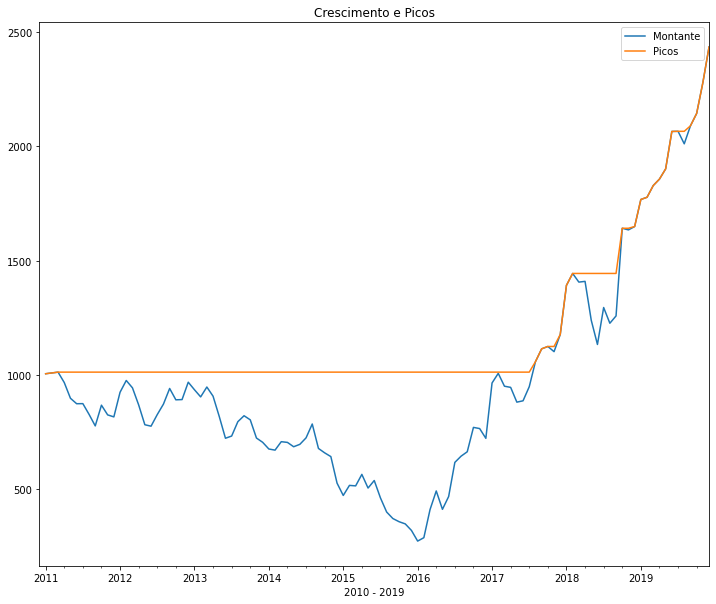

In [42]:
# Montantes e Picos
fcq.drawdown(ret_final["Returns"])[["Montante", "Picos"]].plot(title="Crescimento e Picos", 
                                                                 xlabel="2010 - 2019", figsize=(12,10))

<AxesSubplot:title={'center':'Drawdowns'}, xlabel='2010 - 2019'>

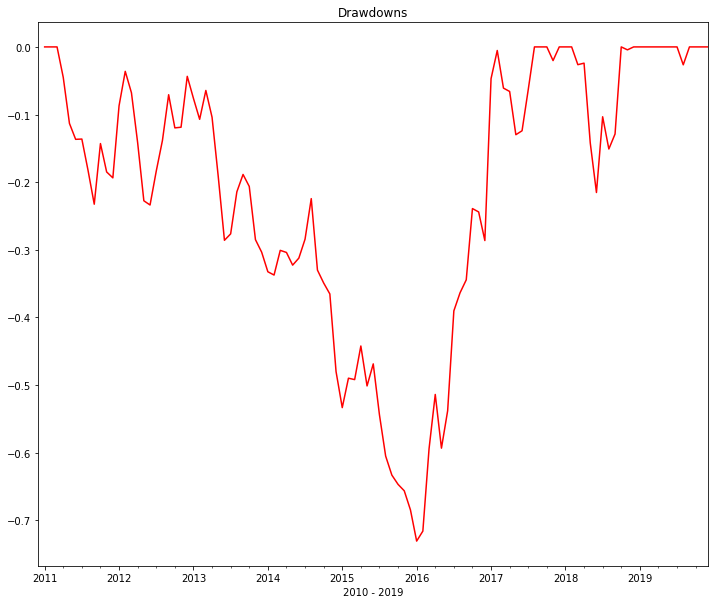

In [43]:
# Drawdown
fcq.drawdown(ret_final["Returns"])['Drawdowns'].plot(title="Drawdowns", 
                                                                 xlabel="2010 - 2019", figsize=(12,10), color='red')

In [44]:
# Max Drawdown
print(-fcq.drawdown(ret_final["Returns"])['Drawdowns'].min())
print(fcq.drawdown(ret_final["Returns"])['Drawdowns'].idxmin())

0.730621592243124
2016-01


## Parte IV - Conclusão

### Por ser uma estratégia simples, acho que não atingi um resultado satisfatório por conta do alto risco que esse método de investimento pode trazer, como observado nos gráficos acimas até o ano de 2017 não obtivemos retornos positivos para o nosso investimento, assim grande parte da nossa estratégia veio apenas nos anos finais, evidenciando a grande volatilidade do portifólio, comprar ações que tiveram um maior volume no mercado no mês passado não implica que elas tiveram bons retornos, e sim que são ações prestigiadas de grandes empresas que podem ter um bom retorno, podem existir outras formas de aplicar esse dinheiro, talvez com o mesmo retorno e um menor risco. 